In [1]:
# Setup iPython environment.
%pylab inline
plt.rc('font',size=20)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Import common libraries.
from __future__ import division
from solvers import *
from utils import *
import ising_eqn_5_sym

# Define common functions.
calc_e,calc_observables,mchApproximation = define_ising_mch_helpers()

# Generate example data set.
n = 5
np.random.seed(0)
h,J = np.random.normal(scale=.1,size=n),np.random.normal(scale=.1,size=n*(n-1)//2)
hJ = np.concatenate((h,J))
p = ising_eqn_5_sym.p(hJ)
sisjTrue = ising_eqn_5_sym.calc_observables(hJ)

allstates = bin_states(n,True)
sample = allstates[random.choice(range(2**n),size=100,replace=True,p=p)]
sisj = pair_corr(sample,concat=True)

# Exact example.

Enumerate all constraint equations and solve them using scipy.optimize.minimize.

In [14]:
# Define function specific to Exact class.
def calc_observables_multipliers(J):
    """
    Calculate observables from probability distribution given Langrangian multipliers.
    """
    E = calc_e(allstates,J)
    return pair_corr( allstates, np.exp(-E-logsumexp(E)),concat=True )

# Declare and call solver.
solver = Exact(n,
               calc_observables_multipliers=calc_observables_multipliers,
               calc_observables=calc_observables)
estMultipliers,soln = solver.solve(constraints=sisjTrue,fsolve_kwargs={})

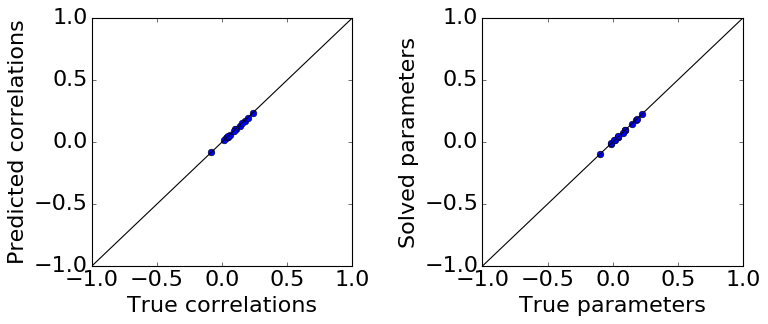

In [15]:
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisjTrue,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='True correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,soln['x'],'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

## MPF example.

In [ ]:
# Declare and call solver.
solver = MPF(n,calc_observables=calc_observables,adj=adj)
estMultipliers,soln = solver.solve(sample)

In [ ]:
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='True correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,estMultipliers,'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Pseudolikelihood

In [ ]:
solver = Pseudo(n,calc_observables=calc_observables)
estMultipliers = solver.solve(sample)

In [ ]:
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='True correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,estMultipliers,'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# Adaptive cluster expansion

In [ ]:
solver = ClusterExpansion(n,calc_observables=calc_observables)

threshold = 0.001
estMultipliers = solver.solve(sample,threshold)

In [ ]:
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='True correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,estMultipliers,'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)

# MCH example.

In [ ]:
# Declare and call solver.
solver = MCH(n,calc_observables=calc_observables,
             sample_size=100,
             sample_method='metropolis',
             mch_approximation=mchApproximation)

# Manually iterate over different parameters.
soln = solver.solve(sisj,maxiter=10)
soln = solver.solve(sisj,initial_guess=soln,maxiter=10,
                    learn_params_kwargs={'maxdlamda':.1,'eta':.1})
estMultipliers = solver.solve(sisj,initial_guess=soln,maxiter=20,
                              learn_params_kwargs={'maxdlamda':.05,'eta':.05})

In [ ]:
fig,ax = plt.subplots(figsize=(10.5,4),ncols=2)
ax[0].plot(sisj,ising_eqn_5_sym.calc_observables(estMultipliers),'o')
ax[0].plot([-1,1],[-1,1],'k-')
ax[0].set(xlabel='True correlations',ylabel='Predicted correlations')

ax[1].plot(hJ,estMultipliers,'o')
ax[1].plot([-1,1],[-1,1],'k-')
ax[1].set(xlabel='True parameters',ylabel='Solved parameters')

fig.subplots_adjust(wspace=.5)